In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import matplotlib.dates as mdates
from windrose import WindroseAxes
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import datasets, linear_model
from tabulate import tabulate
import os

In [4]:
current_path = os.getcwd()
print(current_path)

d:\Work\04Script\01Oceanography\05ApiERA5


In [5]:
#Make Class to Extract from Wind datasets
class wind:
    def __init__(self, dataset):
        self.dataname = dataset #return dataset name
        self.data = Dataset(rf'{dataset}.nc') #Import dataset with NETCDF-4 Module
        self.lon = self.data.variables["longitude"][:].filled(np.nan) #Longitude (.filled(np.nan) is for masking) 
        self.lat = self.data.variables["latitude"][:].filled(np.nan) #Latitude
        self.v10 = self.data.variables["v10"][:].filled(np.nan) 
        self.u10 = self.data.variables ["u10"][:].filled(np.nan)
        time = self.data.variables["time"][:].filled(np.nan)
        time_unit = self.data.variables["time"].getncattr('units')
        time_cal = self.data.variables["time"].getncattr('calendar')
        self.local_time = num2date(time, units=time_unit,calendar= time_cal)
        self.data.close()
    def convert_csv(self, **kwargs):
        wnd_speed= np.sqrt(self.u10**2+self.v10**2)
        wnd_dir = np.mod(270-np.rad2deg(np.arctan2(self.v10, self.u10)),360)
        ext_lon = kwargs["coor"][0]
        ext_lat = kwargs["coor"][1]

        sq_dif_lon = (self.lon-ext_lon)**2
        sq_dif_lat = (self.lat-ext_lat)**2
        index_lon = sq_dif_lon.argmin()
        index_lat = sq_dif_lat.argmin()
        print(self.lon[index_lon], self.lat[index_lat])

        time_str = []
        for x in self.local_time:
            time_str.append(str(x))
        time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

        d = {'time': time_list, 'wnd_speed(m/s)': wnd_speed[:,index_lat, index_lon], 'direction_(deg)': wnd_dir[:,index_lat, index_lon], 'u10': self.u10[:,index_lat, index_lon], 'v10': self.v10[:,index_lat, index_lon]}
        self.df = pd.DataFrame(data = d, index = None)
        self.df.to_csv(f'Hasil/{self.dataname}.csv')
        return self.df
    
    def draw_graph(self, coor = [104.3, 0.9], time = False, title = 'Arus Laut'):
        df = self.convert_csv(coor = coor)

        if time == False:
            timestep = slice(None)
        else:
            start = time[0] - df['time'].iloc[0]
            start_time = int(start.total_seconds()/3600)
            end = time[1] - df['time'].iloc[0]
            end_time = int(end.total_seconds()/3600)
            timestep = slice(start_time,end_time)
        
        MaxSpeed = max(df['wnd_speed(m/s)'].iloc[timestep])
        MinSpeed = min(df['wnd_speed(m/s)'].iloc[timestep])
        MeanSpeed = np.average(df['wnd_speed(m/s)'].iloc[timestep])

        print(tabulate([[ 'Maximum Current Speed', str(MaxSpeed)],
                        [ 'Minimum Current Speed', str(MinSpeed)],
                        ['Mean Current Speed', str(MeanSpeed)]      
        ], headers = ['Parameter', 'Value']))

        
        fig, ax1 = plt.subplots(1,2, figsize=(22,6), gridspec_kw={'width_ratios': [2, 1]})
        color = 'tab:blue'
        ax1[0].set_xlabel('Date')
        ax1[0].set_ylabel('Wind_Speed (m/s)', color = color)
        ax1[0].plot(df['time'].iloc[timestep], df['wnd_speed(m/s)'].iloc[timestep], color = color)
        ax1[0].tick_params(axis='y', labelcolor = color)
        ax1[0].set_title(title)

        ax2 = ax1[0].twinx()
        color = 'tab:red'
        ax2.set_ylabel("Wind_Direction (Deg)", color = color)
        ax2.plot(df['time'].iloc[timestep], df['direction_(deg)'].iloc[timestep], marker = 'o',color = color, linewidth = 0, markersize = 2)
        ax2.tick_params(axis='y', labelcolor = color)

        max_u = max(abs(df['u10']))
        max_v = max(abs(df['v10']))

        ax1[1].set_xlabel('U10 (m/s)')
        ax1[1].set_ylabel('V10 (m/s)')
        sc = ax1[1].scatter((df['u10'].iloc[timestep]*-1), (df['v10'].iloc[timestep]*-1), c = df['wnd_speed(m/s)'].iloc[timestep], cmap = 'plasma', s = 3)
        ax1[1].axvline(0, c='black', ls='--')
        ax1[1].axhline(0, c='black', ls='--')
        ax1[1].set_xlim(-1*max_u, max_u)
        ax1[1].set_ylim(-1*max_v, max_v)
        fig.colorbar(sc, label = 'Wind_speed (m/s)')

        wr = WindroseAxes.from_ax()
        wr.bar(df['direction_(deg)'].iloc[timestep], df['wnd_speed(m/s)'].iloc[timestep], edgecolor = 'white', normed = True, cmap = cm.cool)
        wr.set_title(f'Windrose {title}')
        wr.set_legend()
        
        plt.show()
    

In [14]:
class wave:
    def __init__(self, dataset):
        self.dataname = dataset
        self.data = Dataset(rf'{dataset}.nc')
        self.lon = self.data.variables["longitude"][:].filled(np.nan)
        self.lat = self.data.variables["latitude"][:].filled(np.nan)
        self.swh = self.data.variables["swh"][:].filled(np.nan)
        self.mwp = self.data.variables ["mwp"][:].filled(np.nan)
        self.mwd = self.data.variables['mwd'][:].filled(np.nan)
        time = self.data.variables["time"][:].filled(np.nan)
        time_unit = self.data.variables["time"].getncattr('units')
        time_cal = self.data.variables["time"].getncattr('calendar')
        self.local_time = num2date(time, units=time_unit,calendar= time_cal)
        self.data.close()
    def convert_csv(self, **kwargs):
        ext_lon = kwargs["coor"][0]
        ext_lat = kwargs["coor"][1]

        sq_dif_lon = (self.lon-ext_lon)**2
        sq_dif_lat = (self.lat-ext_lat)**2
        index_lon = sq_dif_lon.argmin()
        index_lat = sq_dif_lat.argmin()
        print(self.lon[index_lon], self.lat[index_lat])

        time_str = []
        for x in self.local_time:
            time_str.append(str(x))
        time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

        d = {'time': time_list, 'swh(m)': self.swh[:,index_lat, index_lon],'period(s)': self.mwp[:,index_lat,index_lon] ,'direction_(deg)': self.mwd[:,index_lat, index_lon]}
        self.df = pd.DataFrame(data = d, index = None)
        self.df.to_csv(f'Hasil/{self.dataname}.csv')
        return self.df
    
    def draw_graph(self, coor = [104.3, 0.9], time = False, title = 'Arus Laut'):
        df = self.convert_csv(coor = coor)

        if time == False:
            timestep = slice(None)
        else:
            start = time[0] - df['time'].iloc[0]
            start_time = int(start.total_seconds()/3600)
            end = time[1] - df['time'].iloc[0]
            end_time = int(end.total_seconds()/3600)
            timestep = slice(start_time,end_time)
        
        MaxHeight = max(df['swh(m)'].iloc[timestep])
        MinHeight = min(df['swh(m)'].iloc[timestep])
        MeanHeight = np.average(df['swh(m)'].iloc[timestep])
        MaxPeriod = max(df['period(s)'].iloc[timestep])
        MinPeriod = min(df['period(s)'].iloc[timestep])
        MeanPeriod = np.average(df['period(s)'].iloc[timestep])

        print(tabulate([[ 'Maximum Wave Height', str(MaxHeight)],
                    [ 'Minimum Wave Height', str(MinHeight)],
                    ['Mean Wave Height', str(MeanHeight)],
                    ['Max Wave Period', str(MaxPeriod)],
                    ['Min Wave Period', str(MinPeriod)],
                    ['Mean Wave Period', str(MeanPeriod)] 
        ], headers = ['Parameter', 'Value']))

        
        fig,ax = plt.subplots(figsize=(18,8))
        #fig, ax1 = plt.subplots(1,2, figsize=(22,6), gridspec_kw={'width_ratios': [2, 1]})
        color = 'tab:blue'
        ax.set_xlabel('Date')
        ax.set_ylabel('Wave Height(m)', color = color)
        ax.plot(df['time'].iloc[timestep], df['swh(m)'].iloc[timestep], color = color)
        ax.tick_params(axis='y', labelcolor = color)
        ax.set_title(title)

        ax2 = ax.twinx()
        color = 'tab:red'
        ax2.set_ylabel("Wave_Direction (Deg)", color = color)
        ax2.plot(df['time'].iloc[timestep], df['direction_(deg)'].iloc[timestep], marker = 'o',color = color, linewidth = 0, markersize = 2)
        ax2.spines['right'].set_position(('outward',50))
        ax2.tick_params(axis='y', labelcolor = color)

        ax3 = ax.twinx()
        color = 'tab:green'
        ax3.set_ylabel("Wave Period (s)", color = color)
        ax3.plot(df['time'].iloc[timestep], df['period(s)'].iloc[timestep], marker = 'o',color = color, linewidth = 0, markersize = 2)
        ax3.tick_params(axis='y', labelcolor = color)


        # max_u = max(abs(df['u10']))
        # max_v = max(abs(df['v10']))

        # ax1[1].set_xlabel('U10 (m/s)')
        # ax1[1].set_ylabel('V10 (m/s)')
        # sc = ax1[1].scatter((df['u10'].iloc[timestep]*-1), (df['v10'].iloc[timestep]*-1), c = df['wnd_speed(m/s)'].iloc[timestep], cmap = 'plasma', s = 3)
        # ax1[1].axvline(0, c='black', ls='--')
        # ax1[1].axhline(0, c='black', ls='--')
        # ax1[1].set_xlim(-1*max_u, max_u)
        # ax1[1].set_ylim(-1*max_v, max_v)
        # fig.colorbar(sc, label = 'Wind_speed (m/s)')

        wr = WindroseAxes.from_ax()
        wr.bar(df['direction_(deg)'].iloc[timestep], df['swh(m)'].iloc[timestep], edgecolor = 'white', normed = True, cmap = cm.cool)
        wr.set_title(f'Waverose {title}')
        wr.set_legend()

        plt.show()
    

104.25 0.8
Parameter                  Value
---------------------  ---------
Maximum Current Speed  9.71153
Minimum Current Speed  0.0553232
Mean Current Speed     5.53005


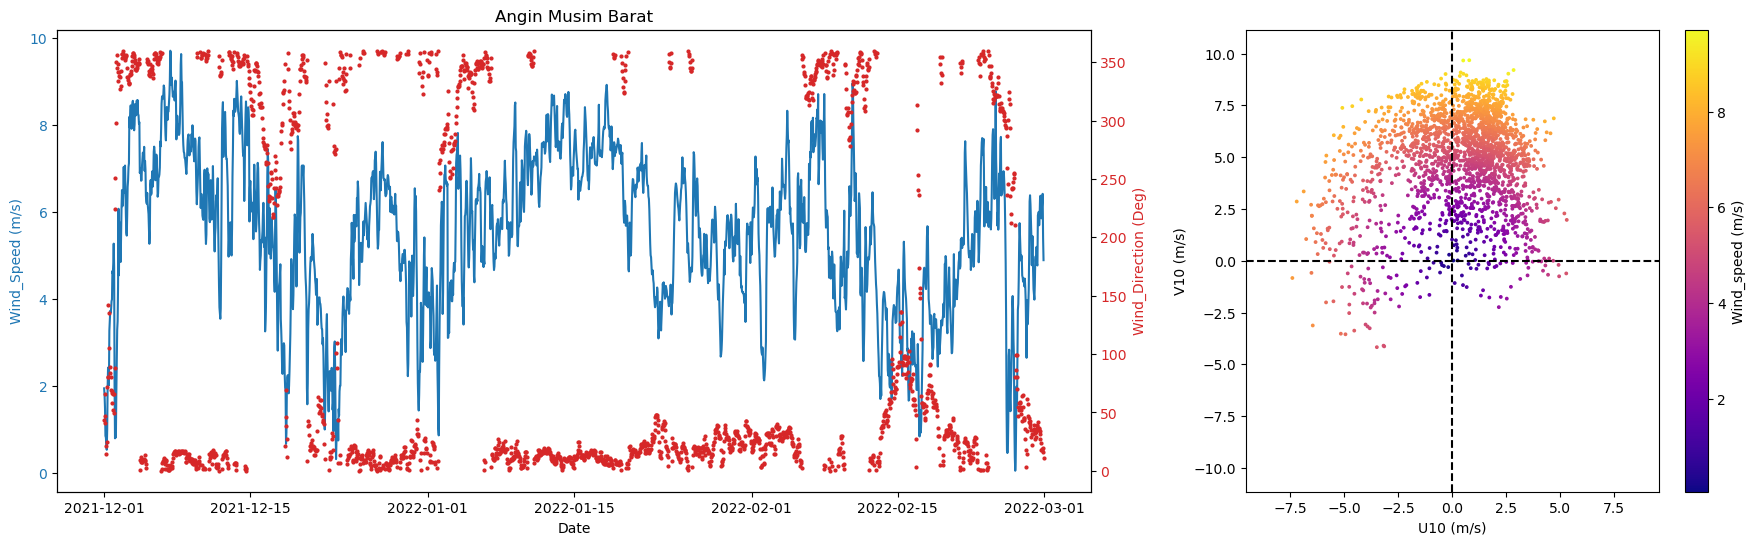

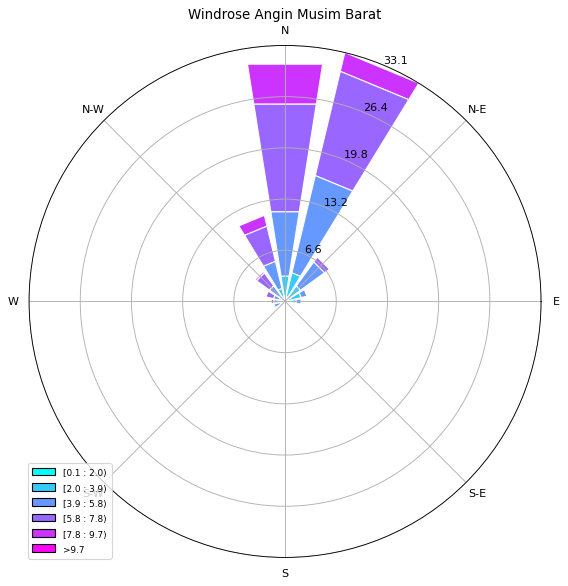

104.25 0.8
Parameter                  Value
---------------------  ---------
Maximum Current Speed  8.33073
Minimum Current Speed  0.0396214
Mean Current Speed     3.09405


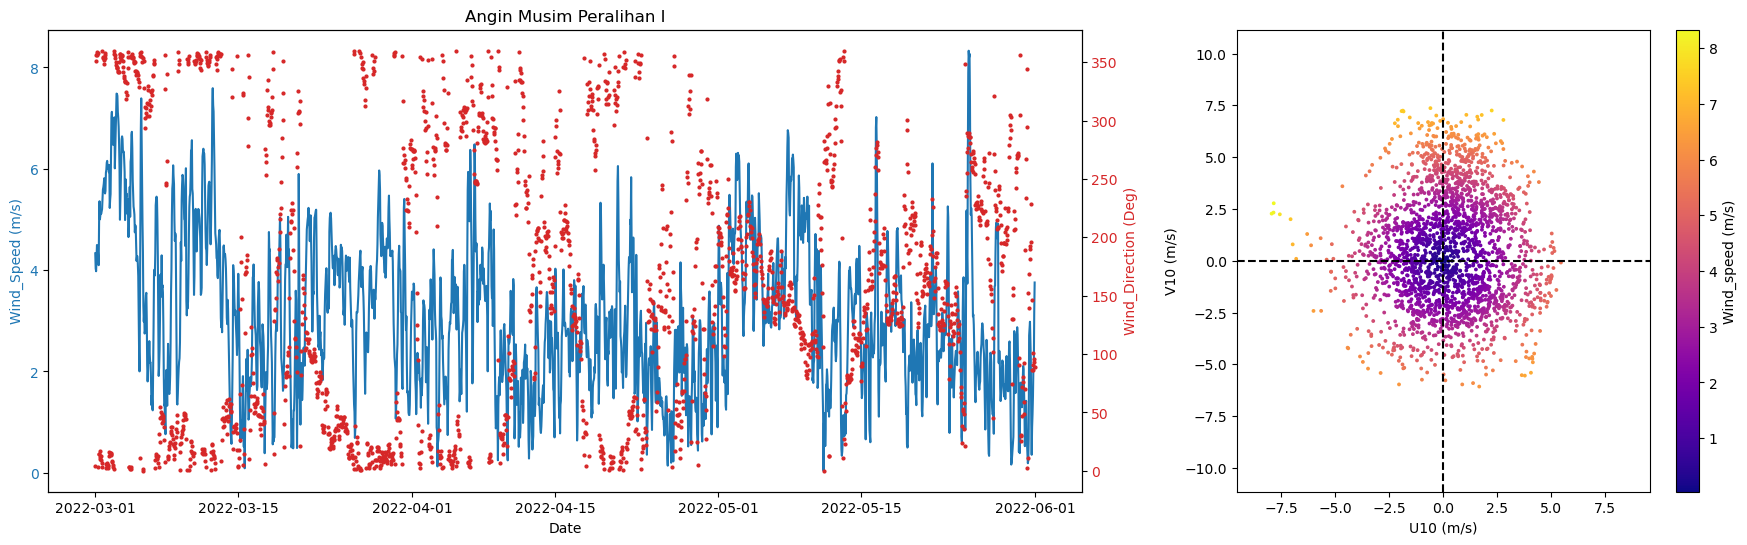

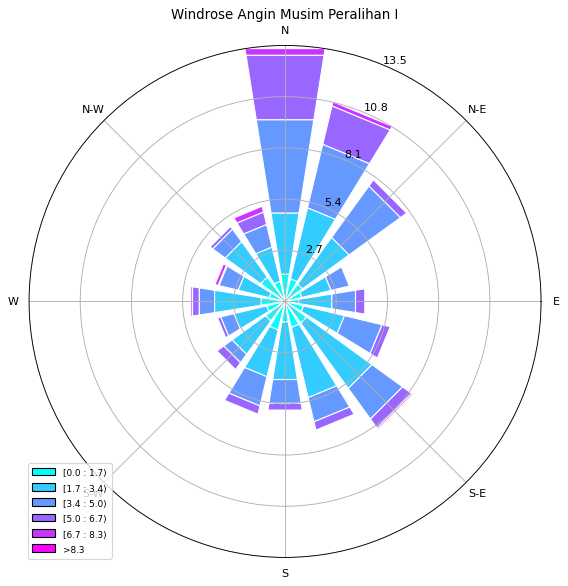

104.25 0.8
Parameter                 Value
---------------------  --------
Maximum Current Speed  8.0064
Minimum Current Speed  0.155874
Mean Current Speed     3.71319


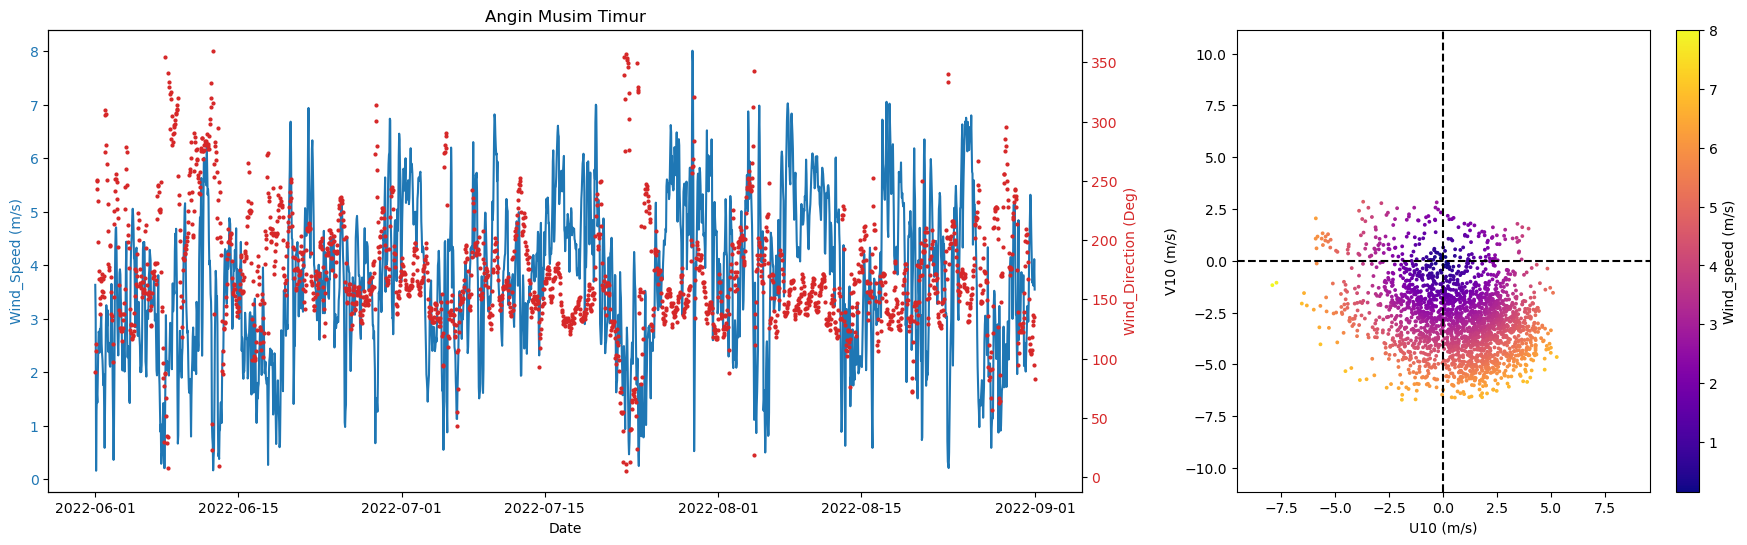

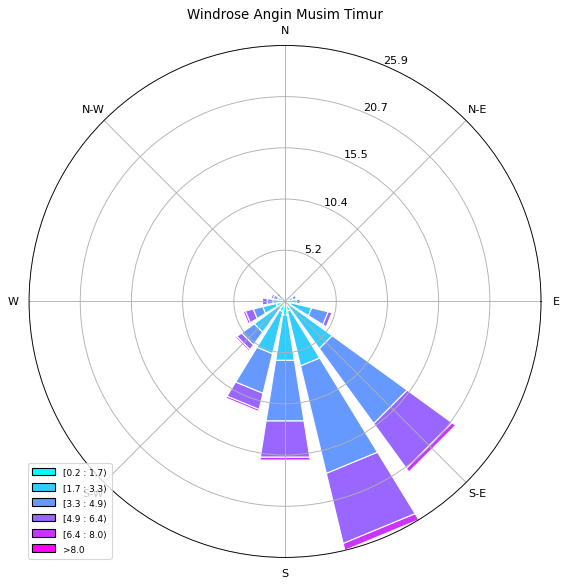

104.25 0.8
Parameter                  Value
---------------------  ---------
Maximum Current Speed  9.86587
Minimum Current Speed  0.0601933
Mean Current Speed     3.83701


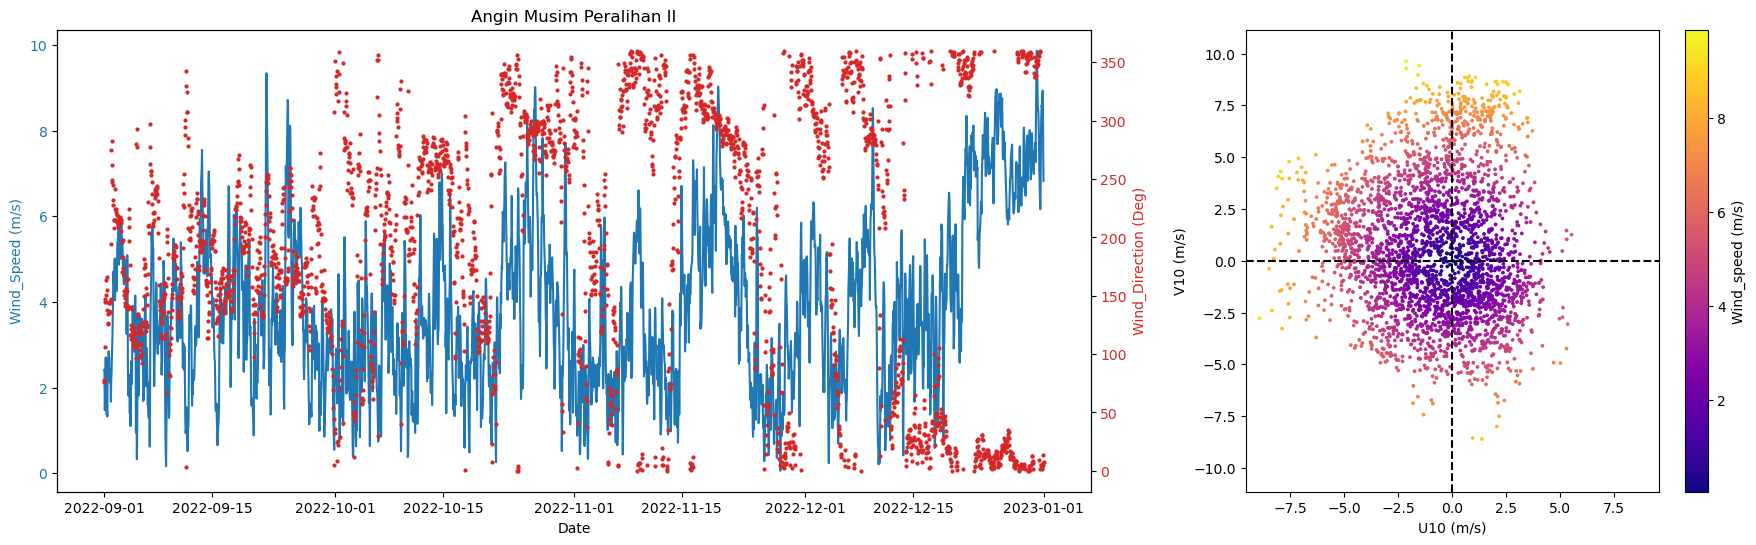

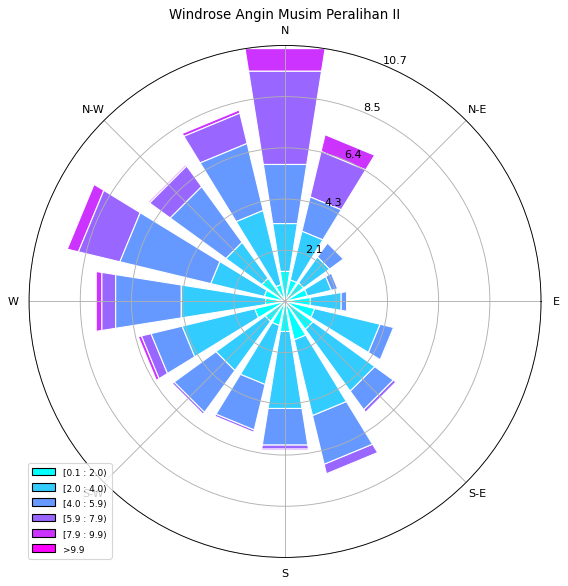

In [30]:
start = [datetime(2021,12,1,00,00,00), datetime(2022,3,1,00,00,00), datetime(2022,6,1,00,00,00), datetime(2022,9,1,00,00,00)]
end = [datetime(2022,3,1,00,00,00), datetime(2022,6,1,00,00,00), datetime(2022,9,1,00,00,00), datetime(2023,12,1,00,00,00)]
musim = ['Musim Barat', 'Musim Peralihan I', 'Musim Timur', 'Musim Peralihan II']

for i in range(len(start)):
    windy = wind('Data Angin 2022')
    start_time = start[i]
    end_time = end[i]
    windy.draw_graph(coor = [104.3, 0.8], time = [start_time, end_time], title = f"Angin {musim[i]}")


104.25 0.8
Parameter                  Value
---------------------  ---------
Maximum Current Speed  9.71153
Minimum Current Speed  0.0553232
Mean Current Speed     5.53005


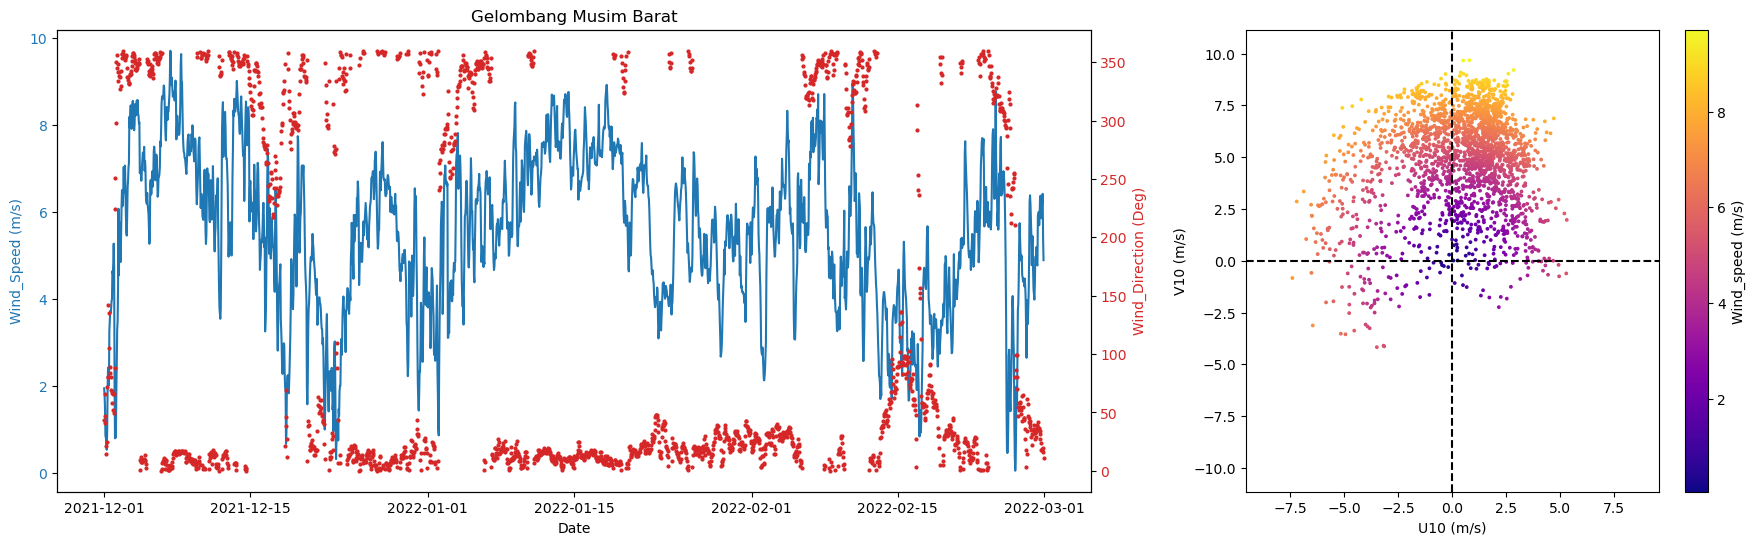

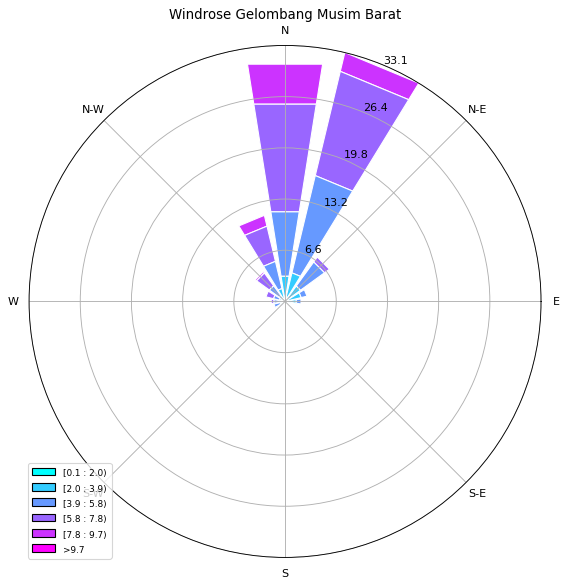

104.25 0.8
Parameter                  Value
---------------------  ---------
Maximum Current Speed  8.33073
Minimum Current Speed  0.0396214
Mean Current Speed     3.09405


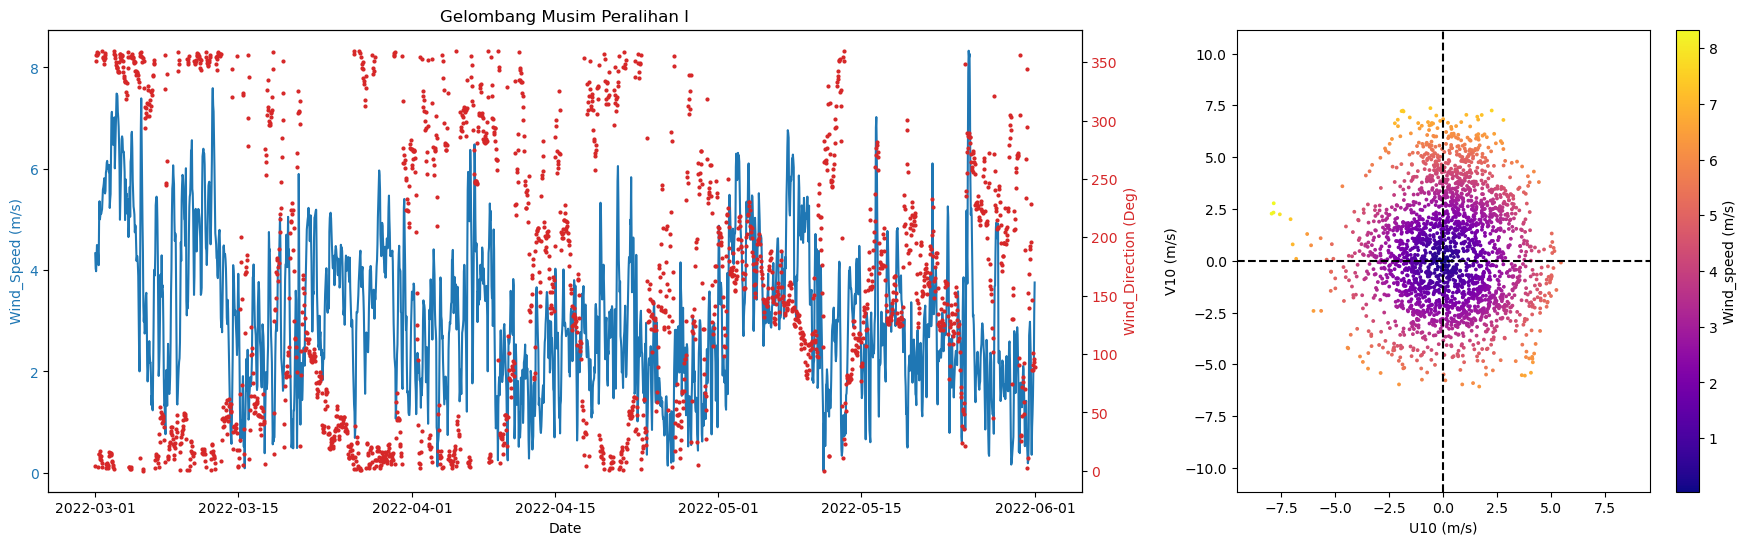

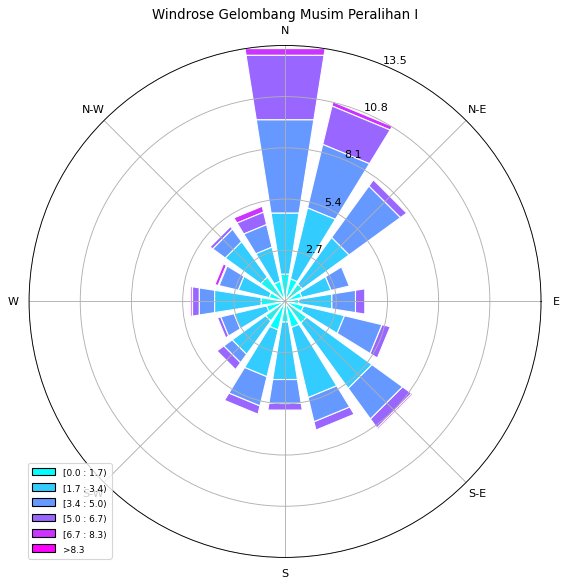

104.25 0.8
Parameter                 Value
---------------------  --------
Maximum Current Speed  8.0064
Minimum Current Speed  0.155874
Mean Current Speed     3.71319


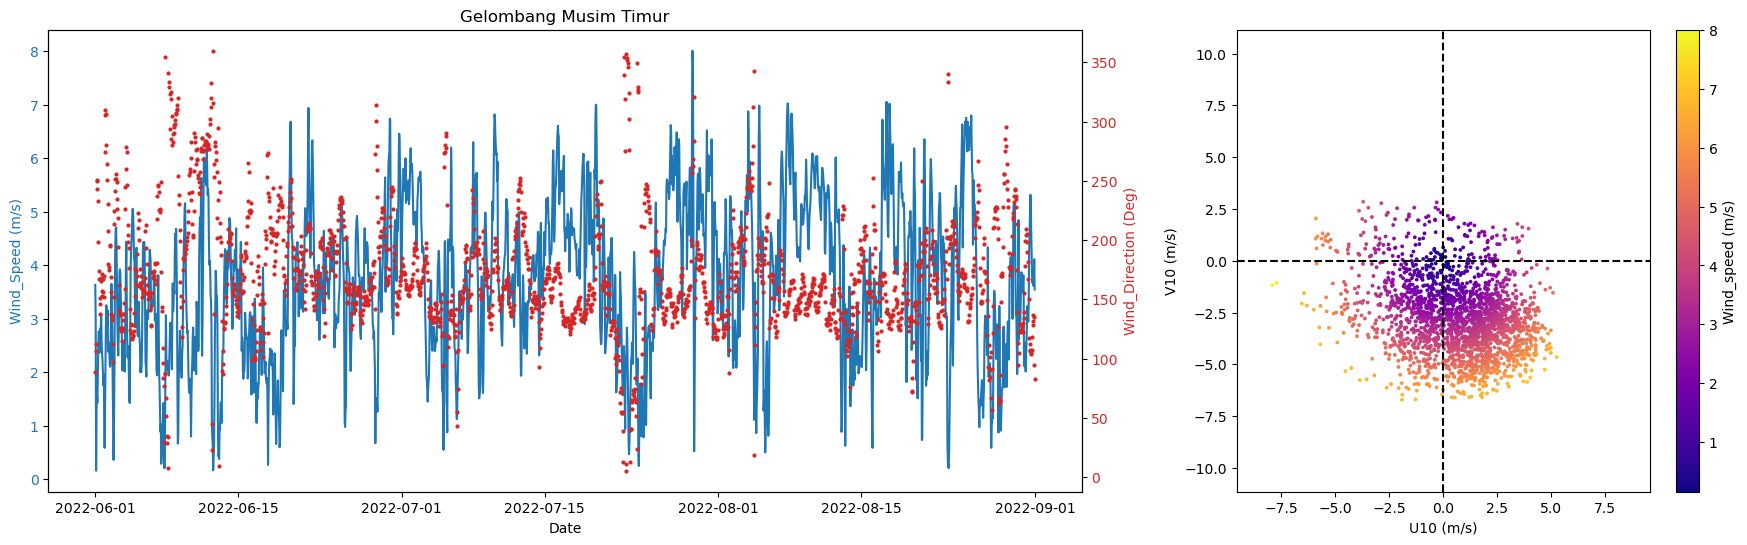

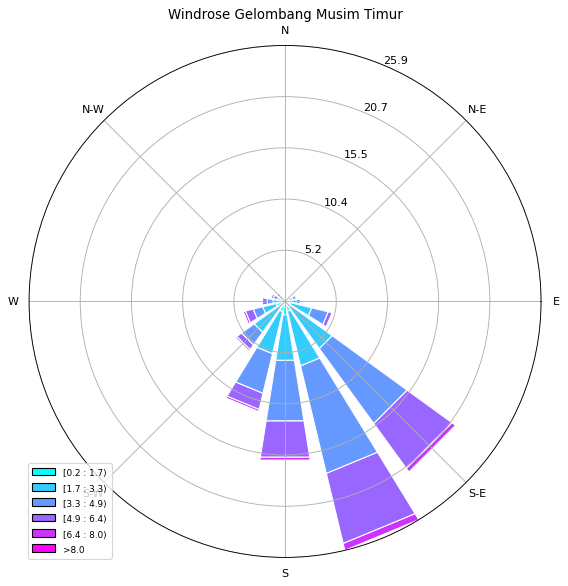

104.25 0.8
Parameter                  Value
---------------------  ---------
Maximum Current Speed  9.86587
Minimum Current Speed  0.0601933
Mean Current Speed     3.83701


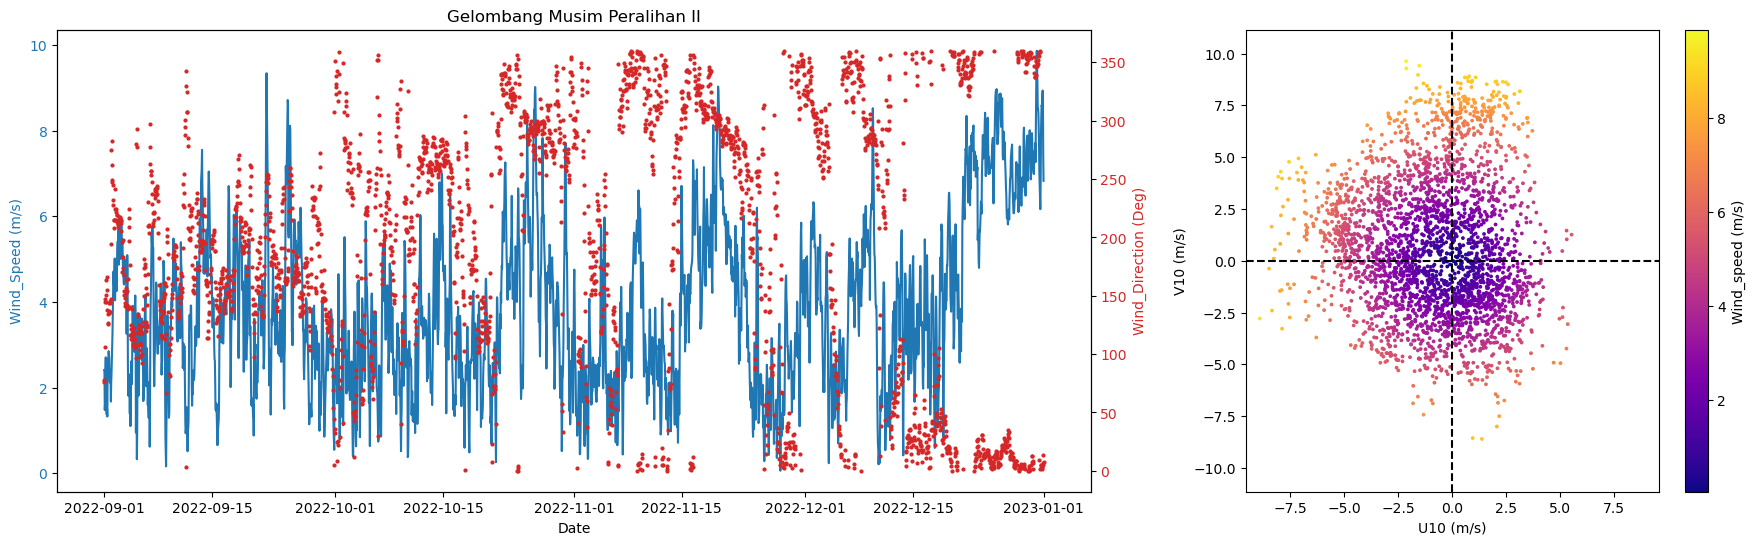

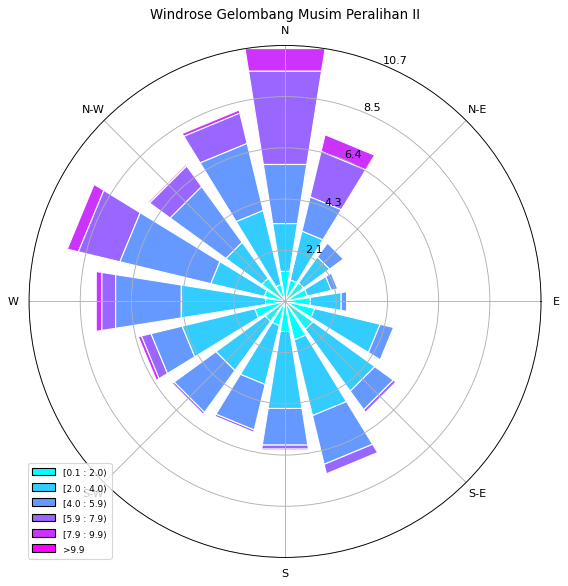

In [32]:
start = [datetime(2021,12,1,00,00,00), datetime(2022,3,1,00,00,00), datetime(2022,6,1,00,00,00), datetime(2022,9,1,00,00,00)]
end = [datetime(2022,3,1,00,00,00), datetime(2022,6,1,00,00,00), datetime(2022,9,1,00,00,00), datetime(2023,12,1,00,00,00)]
musim = ['Musim Barat', 'Musim Peralihan I', 'Musim Timur', 'Musim Peralihan II']

for i in range(len(start)):
    wavy = wave("Gelombang 2023")
    start_time = start[i]
    end_time = end[i]
    windy.draw_graph(coor = [104.3, 0.8], time = [start_time, end_time], title = f"Gelombang {musim[i]}")


In [ ]:
# def convert_csv_wind(dataset, **kwargs):
#     """
#   Get CSV data from a dataset.
#   Args:
#     dataset: Set Path to Dataset File (.nc)
#     **kwargs: Keyword arguments.
#     **Keyword argument:**
#     * `coor`: A list of two numbers specifying the [Longitude, Latitude] of the point to get the data for. 
#     The coordinates should be in decimal degrees.

  
#   Returns:
#     A Dataframe CSV.
#   """
#     ###Import data From Netcdf 
#     data = Dataset(rf'{dataset}.nc')
#     lon = data.variables["longitude"][:].filled(np.nan)
#     lat = data.variables["latitude"][:].filled(np.nan)
#     v10 = data.variables["v10"][:].filled(np.nan)
#     u10 = data.variables ["u10"][:].filled(np.nan)

#     time = data.variables["time"][:].filled(np.nan)
#     time_unit = data.variables["time"].getncattr('units')
#     time_cal = data.variables["time"].getncattr('calendar')
#     local_time = num2date(time, units=time_unit,calendar= time_cal)

#     wnd_speed= np.sqrt(u10**2+v10**2)
#     wnd_dir = np.mod(270-np.rad2deg(np.arctan2(v10, u10)),360)
#     ext_lon = kwargs["coor"][0]
#     ext_lat = kwargs["coor"][1]

#     sq_dif_lon = (lon-ext_lon)**2
#     sq_dif_lat = (lat-ext_lat)**2
#     index_lon = sq_dif_lon.argmin()
#     index_lat = sq_dif_lat.argmin()
#     print(lon[index_lon], lat[index_lat])

#     time_str = []
#     for x in local_time:
#       time_str.append(str(x))
#     time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

#     d = {'time': time_list, 'wnd_speed(m/s)': wnd_speed[:,index_lat, index_lon], 'direction_(deg)': wnd_dir[:,index_lat, index_lon], 'u10': u10[:,index_lat, index_lon], 'v10': v10[:,index_lat, index_lon]}
#     df = pd.DataFrame(data = d, index = None)
#     df.to_csv(f'Hasil/{dataset}.csv')
#     return df

# def convert_csv_wave(dataset, **kwargs):
#     """
#   Get CSV data from a dataset.
#   Args:
#     dataset: Set Path to Dataset File (.nc)
#     **kwargs: Keyword arguments.
#     **Keyword argument:**
#     * `coor`: A list of two numbers specifying the [Longitude, Latitude] of the point to get the data for. 
#     The coordinates should be in decimal degrees.

  
#   Returns:
#     A Dataframe CSV.
#   """
#     ###Import data From Netcdf 
#     data = Dataset(rf'{dataset}.nc')
#     lon = data.variables["longitude"][:].filled(np.nan)
#     lat = data.variables["latitude"][:].filled(np.nan)
#     swh = data.variables["swh"][:].filled(np.nan)
#     mwp = data.variables ["mwp"][:].filled(np.nan)
#     mwd = data.variables['mwd'][:].filled(np.nan)

#     time = data.variables["time"][:].filled(np.nan)
#     time_unit = data.variables["time"].getncattr('units')
#     time_cal = data.variables["time"].getncattr('calendar')
#     local_time = num2date(time, units=time_unit,calendar= time_cal)

#     ext_lon = kwargs["coor"][0]
#     ext_lat = kwargs["coor"][1]

#     sq_dif_lon = (lon-ext_lon)**2
#     sq_dif_lat = (lat-ext_lat)**2
#     index_lon = sq_dif_lon.argmin()
#     index_lat = sq_dif_lat.argmin()
#     print(lon[index_lon], lat[index_lat])

#     time_str = []
#     for x in local_time:
#       time_str.append(str(x))
#     time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

#     d = {'time': time_list, 'swh(m)': swh[:,index_lat, index_lon],'period(s)': mwp[:,index_lat,index_lon] ,'direction_(deg)': mwd[:,index_lat, index_lon]}
#     df = pd.DataFrame(data = d, index = None)
#     df.to_csv(f'Hasil/{dataset}.csv')
#     return df

In [ ]:
# def draw_graph_wind(dataset, coor = [104.3, 0.9], time = False, title = 'Arus Laut'):
#     df = convert_csv_wind(dataset, coor = coor)

#     if time == False:
#         timestep = slice(None)
#     else:
#         start = time[0] - df['time'].iloc[0]
#         start_time = int(start.total_seconds()/3600)
#         end = time[1] - df['time'].iloc[0]
#         end_time = int(end.total_seconds()/3600)
#         timestep = slice(start_time,end_time)
    
#     MaxSpeed = max(df['wnd_speed(m/s)'].iloc[timestep])
#     MinSpeed = min(df['wnd_speed(m/s)'].iloc[timestep])
#     MeanSpeed = np.average(df['wnd_speed(m/s)'].iloc[timestep])

#     print(tabulate([[ 'Maximum Current Speed', str(MaxSpeed)],
#                     [ 'Minimum Current Speed', str(MinSpeed)],
#                     ['Mean Current Speed', str(MeanSpeed)]      
#     ], headers = ['Parameter', 'Value']))

    
#     fig, ax1 = plt.subplots(1,2, figsize=(22,6), gridspec_kw={'width_ratios': [2, 1]})
#     color = 'tab:blue'
#     ax1[0].set_xlabel('Date')
#     ax1[0].set_ylabel('Wind_Speed (m/s)', color = color)
#     ax1[0].plot(df['time'].iloc[timestep], df['wnd_speed(m/s)'].iloc[timestep], color = color)
#     ax1[0].tick_params(axis='y', labelcolor = color)
#     ax1[0].set_title(title)

#     ax2 = ax1[0].twinx()
#     color = 'tab:red'
#     ax2.set_ylabel("Wind_Direction (Deg)", color = color)
#     ax2.plot(df['time'].iloc[timestep], df['direction_(deg)'].iloc[timestep], marker = 'o',color = color, linewidth = 0, markersize = 2)
#     ax2.tick_params(axis='y', labelcolor = color)

#     max_u = max(abs(df['u10']))
#     max_v = max(abs(df['v10']))

#     ax1[1].set_xlabel('U10 (m/s)')
#     ax1[1].set_ylabel('V10 (m/s)')
#     sc = ax1[1].scatter((df['u10'].iloc[timestep]*-1), (df['v10'].iloc[timestep]*-1), c = df['wnd_speed(m/s)'].iloc[timestep], cmap = 'plasma', s = 3)
#     ax1[1].axvline(0, c='black', ls='--')
#     ax1[1].axhline(0, c='black', ls='--')
#     ax1[1].set_xlim(-1*max_u, max_u)
#     ax1[1].set_ylim(-1*max_v, max_v)
#     fig.colorbar(sc, label = 'Wind_speed (m/s)')

#     wr = WindroseAxes.from_ax()
#     wr.bar(df['direction_(deg)'].iloc[timestep], df['wnd_speed(m/s)'].iloc[timestep], edgecolor = 'white', normed = True, cmap = cm.cool)
#     wr.set_title(f'Windrose {title}')
#     wr.set_legend()
    
#     plt.show()




# def draw_graph_wave(dataset, coor = [104.3, 0.9], time = False, title = 'Arus Laut'):
#     df = convert_csv_wave(dataset, coor = coor)
#     if time == False:
#         timestep = slice(None)
#     else:
#         start = time[0] - df['time'].iloc[0]
#         start_time = int(start.total_seconds()/3600)
#         end = time[1] - df['time'].iloc[0]
#         end_time = int(end.total_seconds()/3600)
#         timestep = slice(start_time,end_time)
    
#     MaxHeight = max(df['swh(m)'].iloc[timestep])
#     MinHeight = min(df['swh(m)'].iloc[timestep])
#     MeanHeight = np.average(df['swh(m)'].iloc[timestep])
#     MaxPeriod = max(df['period(s)'].iloc[timestep])
#     MinPeriod = min(df['period(s)'].iloc[timestep])
#     MeanPeriod = np.average(df['period(s)'].iloc[timestep])

#     print(tabulate([[ 'Maximum Wave Height', str(MaxHeight)],
#                     [ 'Minimum Wave Height', str(MinHeight)],
#                     ['Mean Wave Height', str(MeanHeight)],
#                     ['Max Wave Period', str(MaxPeriod)],
#                     ['Min Wave Period', str(MinPeriod)],
#                     ['Mean Wave Period', str(MeanPeriod)] 
#     ], headers = ['Parameter', 'Value']))

#     fig,ax = plt.subplots(figsize=(18,8))
#     #fig, ax1 = plt.subplots(1,2, figsize=(22,6), gridspec_kw={'width_ratios': [2, 1]})
#     color = 'tab:blue'
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Wave Height(m)', color = color)
#     ax.plot(df['time'].iloc[timestep], df['swh(m)'].iloc[timestep], color = color)
#     ax.tick_params(axis='y', labelcolor = color)
#     ax.set_title(title)

#     ax2 = ax.twinx()
#     color = 'tab:red'
#     ax2.set_ylabel("Wave_Direction (Deg)", color = color)
#     ax2.plot(df['time'].iloc[timestep], df['direction_(deg)'].iloc[timestep], marker = 'o',color = color, linewidth = 0, markersize = 2)
#     ax2.spines['right'].set_position(('outward',50))
#     ax2.tick_params(axis='y', labelcolor = color)

#     ax3 = ax.twinx()
#     color = 'tab:green'
#     ax3.set_ylabel("Wave Period (s)", color = color)
#     ax3.plot(df['time'].iloc[timestep], df['period(s)'].iloc[timestep], marker = 'o',color = color, linewidth = 0, markersize = 2)
#     ax3.tick_params(axis='y', labelcolor = color)


#     # max_u = max(abs(df['u10']))
#     # max_v = max(abs(df['v10']))

#     # ax1[1].set_xlabel('U10 (m/s)')
#     # ax1[1].set_ylabel('V10 (m/s)')
#     # sc = ax1[1].scatter((df['u10'].iloc[timestep]*-1), (df['v10'].iloc[timestep]*-1), c = df['wnd_speed(m/s)'].iloc[timestep], cmap = 'plasma', s = 3)
#     # ax1[1].axvline(0, c='black', ls='--')
#     # ax1[1].axhline(0, c='black', ls='--')
#     # ax1[1].set_xlim(-1*max_u, max_u)
#     # ax1[1].set_ylim(-1*max_v, max_v)
#     # fig.colorbar(sc, label = 'Wind_speed (m/s)')

#     wr = WindroseAxes.from_ax()
#     wr.bar(df['direction_(deg)'].iloc[timestep], df['swh(m)'].iloc[timestep], edgecolor = 'white', normed = True, cmap = cm.cool)
#     wr.set_title(f'Waverose {title}')
#     wr.set_legend()
    
#     plt.show()